# Preliminaries

In [289]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import scipy.stats as stats
from scipy.stats import skew, kurtosis
from tqdm.notebook import tqdm
from datetime import date, timedelta
from pandas_datareader import data as pdr
import yfinance as yf
np.random.seed(42)

# Google stock data

In [255]:
yf.pdr_override()
start = date(2021, 1, 1)
end = date(2022, 1, 1)
googlframe = pdr.get_data_yahoo("GOOGL", start="2020-01-01", end="2021-01-01")
display(googlframe.head())
display(googlframe.tail())

[*********************100%***********************]  1 of 1 completed


Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2020-01-02  67.420502  68.433998  67.324501  68.433998  68.433998  27278000
2020-01-03  67.400002  68.687500  67.365997  68.075996  68.075996  23408000
2020-01-06  67.581497  69.916000  67.550003  69.890503  69.890503  46768000
2020-01-07  70.023003  70.175003  69.578003  69.755501  69.755501  34330000
2020-01-08  69.740997  70.592499  69.631500  70.251999  70.251999  35314000

Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2020-12-24  86.449997  87.120499  86.217499  86.708000  86.708000   9312000
2020-12-28  87.245499  89.349998  87.091003  88.697998  88.697998  27650000
2020-12-29  89.361504  89.423500  87.755501  87.888000  87.888000  19726000
2020-12-30  88.250000  88.388000  86.400002  86.812500  86.812500  21026000
2020-12-31  86.863503  87.875000  86.804497  87.632004  87.632004  21070000

<AxesSubplot:xlabel='Date'>

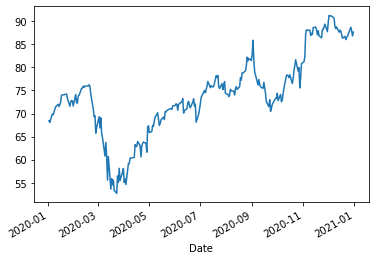

In [256]:
googlframe['Adj Close']['2020-01-01':'2021-01-01'].plot()

# SDE

$d S_{t}= r S_{t} d t+\sigma S_{t} dW_{t}$

In [91]:
from numpy import sqrt, exp, cumsum, sum, maximum, mean
from numpy.random import standard_normal

# Parameters

In [481]:
S0 = 87.63   # initial price
K = 100      # strike price
r = 0.01     # risk-free interest rate
sigma = 0.15 # volatility
T0 = date.today() # today's date
T1 = date(2023,12,1)  # start date of asian option average
T2 = date(2023,12,31) # maturity date
# T2 = T0 + timedelta(days=5)
T = ((T2-T0).days)/365 # time to maturity in years
N = (T2-T0).days # number of time steps
dt = T/N     # time step size
M = 1000     # number of simulations

In [475]:
print(T)
print(N)
print(dt)
print((T1-T0).days)
(T2-T1).days

0.4575342465753425
167
0.0027397260273972603
137


30

# Base class for random walk models

In [432]:
class BaseSimulator:
    def __init__(self, model_name, S0, K, r, sigma, T, N, M, T0, T2, phis=[]):
        self.model_name = model_name
        self.S0 = S0  # initial price
        self.K = K    # strike price
        self.r = r    # risk-free interest rate
        self.sigma = sigma # volatility
        self.T = T    # time to maturity in years
        self.N = N    # number of time steps
        self.dt = T/N # time step size
        self.M = M    # number of simulations
        self.T0 = T0  # start date
        self.T2 = T2  # maturity date
        self.realisations = []  # full path of realisations
        self.expiry_prices = [] # expiry prices
        self.phis = phis # sequence of noise
        self.option_price = None # estimated option price
        self.payoffs = None # payoffs of each simulation

    def get_option_price(self, option_type):
        # function for pricing option based on generated realisations
        raise NotImplementedError("Subclass must implement abstract method")

    def run_monte_carlo(self):
        # function for generating random walks/realisations
        raise NotImplementedError("Subclass must implement abstract method")
    
    def plot_n_realisations(self, n=0):
        n = n if n > 0 else self.M
        timeline = pd.date_range(start=self.T0,end=self.T2)
        plt.plot(timeline, self.realisations[:, :n])
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.title(f'Simulated Time Series using {self.model_name} method')
        plt.show()

# Euler-Maruyama method

$S_T=S_0 \exp \left\{\left(r-\frac{1}{2} \sigma^2\right) T+\sigma \phi \sqrt{T}\right\}$  
This is a closed form solution where the final price at expiry can be calculated in one giant step T.  
Integrated over [0,T]

In [261]:
# initialise random values
phi = standard_normal(M)

# Simulate I outcome
S = S0 * exp((r - 0.5 * sigma ** 2) * T + sigma * sqrt(T) * phi)
payoffs = maximum(S-K, 0)

# Calculate the Monte Carlo estimator
C0 = exp(-r * T) * sum(payoffs)/len(payoffs)
print("Estimated present value is %f" % C0)

Estimated present value is 0.516587


# Forward Euler-Maruyama method - slow
$S_{t+\delta t} = S_t(1+r \delta t+\sigma \phi \sqrt{\delta t})$

In [95]:
# function to run one simulation
def simulate_Euler_Maruyama():
    # Initialize the time series
    S = np.zeros(N+1)
    S[0] = S0
    
    # perform one realisation
    for i in range(N):
        _phi = np.random.normal(0, 1)
        S[i+1] = S[i] * (1 + r*dt + sigma*_phi*sqrt(dt))
    return S[-1]

start_time = time.time()
payoffs = maximum(np.array([simulate_Euler_Maruyama() for i in range(M)]) - K, 0)
option_price = exp(-r*T) * sum(payoffs)/len(payoffs)
print("Estimated present value is %f" % option_price)
print("Computation time is: ", round(time.time() - start_time,4))

Estimated present value is 1.545735
Computation time is:  5.2187


In [272]:
class Euler_Maruyama_simulator:
    def __init__(self, S0, K, r, sigma, T, N, M, ):
        self.S0 = S0
        self.K = K    # strike price
        self.r = r    # risk-free interest rate
        self.sigma = sigma # volatility
        self.T = T    # time to maturity in years
        self.N = N    # number of time steps
        self.dt = T/N # time step size
        self.M = M    # number of simulations
        self.realisations = [] # full path of realisations
        self.expiry_price = [] # expiry prices

    def perform_realisation(self):
        # Initialize the time series
        S = np.zeros(self.N+1)
        S[0] = self.S0

        # perform one realisaztion
        for i in range(self.N):
            _phi = np.random.normal(0, 1)
            S[i+1] = S[i] * (1 + self.r*self.dt + self.sigma*_phi*sqrt(self.dt))
        self.realisations.append(S)
        self.expiry_price.append(S[-1])
    
    def run_monte_carlo(self):
        for i in range(self.M) : self.perform_realisation()
        payoffs = maximum(np.array(self.expiry_price) - self.K, 0)
        option_price = exp(-self.r*self.T) * sum(payoffs)/len(payoffs)
        return option_price
    
    def plot_n_realisations(self, n):
        timeline = pd.date_range(start=T0,end=T2)
        for i in range(n):
            plt.plot(timeline, self.realisations[i])
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.title('Simulated Time Series using Euler-Maruyama method')
        plt.show()

In [273]:
start_time = time.time()
EM_simulator = Euler_Maruyama_simulator(S0, K, r, sigma, T, N, M)
EM_option_price = EM_simulator.run_monte_carlo()
print("Estimated present value is %f" % EM_option_price)
print("Computation time is: ", round(time.time() - start_time,4))

Estimated present value is 0.335678
Computation time is:  0.86


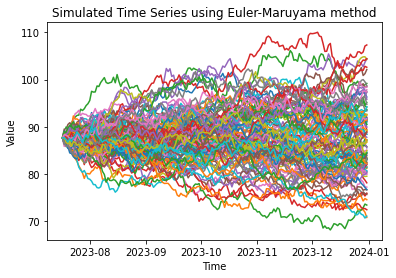

In [274]:
EM_simulator.plot_n_realisations(100)

# Forward Euler-Maruyama method - optimised
$S_{t+\delta t} = S_t(1+r \delta t+\sigma \phi \sqrt{\delta t})$

In [433]:
class Euler_Maruyama_fast_simulator(BaseSimulator):
    def get_option_price(self, option_type="c"):
        # c : call option | other : put option
        # calculate payoffs and dicounted option price
        self.expiry_prices = self.realisations[-1]
        payoffs = (self.expiry_prices - self.K) if (option_type=="c") else (self.K - self.expiry_prices)
        self.payoffs = maximum(payoffs, 0)
        self.option_price = exp(-self.r*self.T) * sum(self.payoffs)/self.M
        return self.option_price
    
    def run_monte_carlo(self):
        # initialise arrays of random variables
        if (len(self.phis) == 0):
            self.phis = standard_normal(size=(self.N, self.M))

        # perform simulations across each time steps
        delta_St = 1 + self.r*self.dt + self.sigma*np.sqrt(self.dt)*self.phis
        self.realisations = self.S0*np.cumprod(delta_St, axis=0)
        
        # prepend initial price S0 to the realisations
        self.realisations = np.concatenate((np.full(shape=(1, self.M), fill_value=self.S0), self.realisations))

### Call Option

In [434]:
start_time = time.time()
em_simulator = Euler_Maruyama_fast_simulator("Euler-Maruyama", S0, K, r, sigma, T, N, M, T0, T2)
em_simulator.run_monte_carlo()
em_option_price = em_simulator.get_option_price()
print("Estimated present value is %f" % em_option_price)
print("Computation time is: ", round(time.time() - start_time,4))

Estimated present value is 0.476486
Computation time is:  0.0142


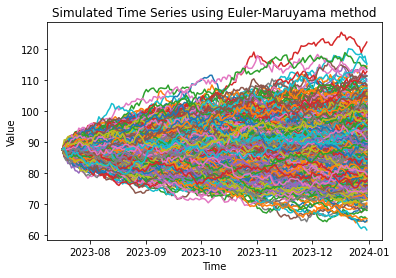

In [435]:
em_simulator.plot_n_realisations()

### Put Option

In [436]:
start_time = time.time()
em_simulator = Euler_Maruyama_fast_simulator("Euler-Maruyama", S0, K, r, sigma, T, N, M, T0, T2)
em_simulator.run_monte_carlo()
em_option_price = em_simulator.get_option_price("p")
print("Estimated present value is %f" % em_option_price)
print("Computation time is: ", round(time.time() - start_time,4))

Estimated present value is 12.831788
Computation time is:  0.013


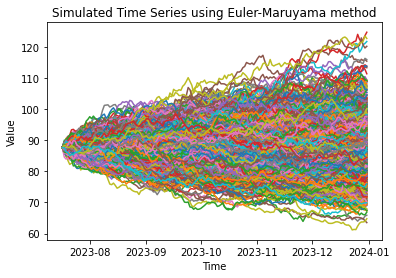

In [437]:
em_simulator.plot_n_realisations()

# Milstein method - slow
$S_{t+\delta t} = S_t\left(1+r \delta t+\sigma \phi \sqrt{\delta t}+\frac{1}{2} \sigma^2\left(\phi^2-1\right) \delta t\right)$

In [104]:
# function to run one simulation
def simulate_Milstein():
    # Initialize the time series
    S = np.zeros(N+1)
    S[0] = S0
    
    # perform one realisaztion
    for i in range(N):
        _phi = np.random.normal(0, 1)
        S[i+1] = S[i] * (1 + r*dt + sigma*_phi*sqrt(dt) + 0.5*(sigma**2)*(_phi**2 - 1)*dt)
    return S[-1]

start_time = time.time()
payoffs = maximum(np.array([simulate_Milstein() for i in range(M)]) - K, 0)
option_price = exp(-r*T) * sum(payoffs)/len(payoffs)
print("Estimated present value is %f" % option_price)
print("Computation time is: ", round(time.time() - start_time,4))

Estimated present value is 1.416357
Computation time is:  5.4183


In [105]:
class Milstein_simulator:
    def __init__(self, S0, K, r, sigma, T, N, M):
        self.S0 = S0
        self.K = K    # strike price
        self.r = r    # risk-free interest rate
        self.sigma = sigma # volatility
        self.T = T    # Final time
        self.N = N    # number of time steps
        self.dt = T/N # time step size
        self.M = M    # number of simulations
        self.realisations = []  # full paths of realisations
        self.expiry_prices = [] # expiry prices
        
    def perform_realisation(self):
        # Initialise the time series
        S = np.zeros(self.N+1)
        S[0] = self.S0

        # perform one realisaztion
        for i in range(self.N):
            _phi = np.random.normal(0, 1)
            S[i+1] = S[i] * (1 + self.r*self.dt + self.sigma*_phi*sqrt(self.dt) + 0.5*(self.sigma**2)*(_phi**2 - 1)*self.dt)
        self.realisations.append(S)
        self.expiry_prices.append(S[-1])
    
    def run_monte_carlo(self):
        for i in range(self.M) : self.perform_realisation()
        payoffs = maximum(np.array(self.expiry_prices) - K, 0)
        option_price = exp(-self.r*self.T) * sum(payoffs)/len(payoffs)
        return option_price
    
    def plot_n_realisations(self, n):
        x = np.linspace(0.0, self.T, self.N+1)
        for i in range(n):
            plt.plot(x, self.realisations[i])
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.title('Simulated Time Series using Milstein method')
        plt.show()

In [106]:
start_time = time.time()
M_simulator = Milstein_simulator(S0, K, r, sigma, T, N, M)
M_option_price = M_simulator.run_monte_carlo()
print("Estimated present value is %f" % M_option_price)
print("Computation time is: ", round(time.time() - start_time,4))

Estimated present value is 1.407625
Computation time is:  5.9229


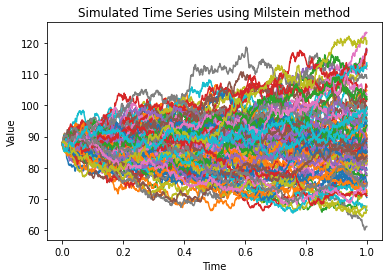

In [107]:
M_simulator.plot_n_realisations(100)

# Milstein method - optimised
$S_{t+\delta t} = S_t\left(1+r \delta t+\sigma \phi \sqrt{\delta t}+\frac{1}{2} \sigma^2\left(\phi^2-1\right) \delta t\right)$

In [438]:
class Milstein_fast_simulator(BaseSimulator):
    def get_option_price(self, option_type="c"):
        # c : call option | other : put option
        # calculate payoffs and dicounted option price
        self.expiry_prices = self.realisations[-1]
        payoffs = (self.expiry_prices - self.K) if (option_type=="c") else (self.K - self.expiry_prices)
        self.payoffs = maximum(payoffs, 0)
        self.option_price = exp(-self.r*self.T) * sum(self.payoffs)/self.M
        return self.option_price
    
    def run_monte_carlo(self):
        # initialise arrays of random variables
        if (len(self.phis) == 0):
            self.phis = standard_normal(size=(self.N, self.M))

        # perform simulations across each time steps
        delta_St = 1 + self.r*self.dt + self.sigma*np.sqrt(self.dt)*self.phis + 0.5*(self.sigma**2)*(np.square(self.phis)-1)*self.dt
        self.realisations = self.S0*np.cumprod(delta_St, axis=0)
        
        # prepend initial price S0 to the realisations
        self.realisations = np.concatenate((np.full(shape=(1, self.M), fill_value=self.S0), self.realisations))

### Call Option

In [439]:
start_time = time.time()
mil_simulator = Milstein_fast_simulator("Milstein", S0, K, r, sigma, T, N, M, T0, T2)
mil_simulator.run_monte_carlo()
mil_option_price = mil_simulator.get_option_price()
print("Estimated present value is %f" % mil_option_price)
print("Computation time is: ", round(time.time() - start_time,4))

Estimated present value is 0.440530
Computation time is:  0.0142


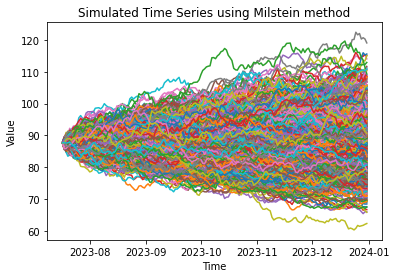

In [440]:
mil_simulator.plot_n_realisations()

### Put Option

In [441]:
start_time = time.time()
mil_simulator = Milstein_fast_simulator("Milstein", S0, K, r, sigma, T, N, M, T0, T2)
mil_simulator.run_monte_carlo()
mil_option_price = mil_simulator.get_option_price("p")
print("Estimated present value is %f" % mil_option_price)
print("Computation time is: ", round(time.time() - start_time,4))

Estimated present value is 12.288308
Computation time is:  0.013


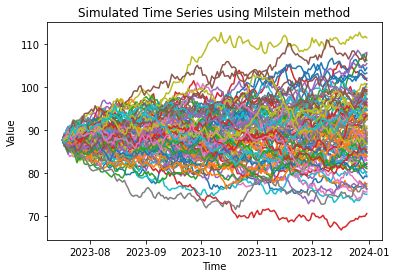

In [442]:
mil_simulator.plot_n_realisations(100)

# Monte Carlo Simulator
The same set of phis is used for both Euler-Maruyama and Milstein methods for comparison.

In [423]:
class MC_simulator:
    def __init__(self, S0, K, r, sigma, T, N, I):
        self.S0 = S0  # initial asset price
        self.K = K    # strike price
        self.r = r    # risk-free interest rate
        self.sigma = sigma # volatility
        self.T = T    # Final time
        self.N = N    # number of time steps
        self.dt = T/N # time step size
        self.I = I    # number of simulations
        self.Milstein_realisations = [] # full path of realisations using Milstein
        self.Milstein_expiry_prices = []
        self.Euler_Maruyama_realisations = [] # full path of realisations using Euler Maruyama
        self.Euler_Maruyama_expiry_prices = []
        self.phis = None # sequence of noise
    
    def perform_Euler_Maruyama_realisation(self):
        # Initialize the time series
        S = np.zeros(self.N+1)
        S[0] = self.S0

        # perform one realisation
        for i in range(self.N):
            S[i+1] = S[i] * (1 + self.r*self.dt + self.sigma*self.phis[i]*sqrt(self.dt))
        self.Euler_Maruyama_realisations.append(S)
        self.Euler_Maruyama_expiry_prices.append(S[-1])
        
    def perform_Milstein_realisation(self):
        # Initialize the time series
        S = np.zeros(self.N+1)
        S[0] = self.S0

        # perform one realisation
        for i in range(self.N):
            S[i+1] = S[i] * (1 + self.r*self.dt + sigma*self.phis[i]*sqrt(self.dt) + 0.5*(self.sigma**2)*(self.phis[i]**2 - 1)*self.dt)
        self.Milstein_realisations.append(S)
        self.Milstein_expiry_prices.append(S[-1])
    
    def calculate_option_price(self, expiry_prices):
        payoffs = maximum(np.array(expiry_prices) - self.K, 0)
        option_price = exp(-self.r*self.T) * sum(payoffs)/len(payoffs)
        return option_price
        
    def run_monte_carlo(self):
        # Run I number of simulations
        print('Start running simulations...')
        for i in tqdm(range(self.I)):
            self.phis = standard_normal(self.N)
            self.perform_Euler_Maruyama_realisation()
            self.perform_Milstein_realisation()
        
        # price the option
        EM_option_price = self.calculate_option_price(self.Euler_Maruyama_expiry_prices)
        M_option_price = self.calculate_option_price(self.Milstein_expiry_prices)
        return (EM_option_price, M_option_price)
    
    def plot_n_realisations(self, n):
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 6))
        # plots Euler-Maruyama realisations
        x = np.linspace(0.0, self.T, self.N+1)
        for i in range(n):
            axes[0].plot(x, self.Euler_Maruyama_realisations[i])   
        axes[0].set_xlabel('Time')
        axes[0].set_ylabel('Value')
        axes[0].set_title('Simulated Time Series using Euler-Maruyama method')
        
        # plots Milstein realisations
        for i in range(n):
            axes[1].plot(x, self.Milstein_realisations[i])   
        axes[1].set_xlabel('Time')
        axes[1].set_ylabel('Value')
        axes[1].set_title('Simulated Time Series using Milstein method')
        
        fig.tight_layout()
        plt.show()
    
    def comparing_ith_realisations(self, ith_rls):
        x = np.linspace(0.0, self.T, self.N+1)
        plt.figure(figsize=(13, 6))
        plt.plot(x, self.Euler_Maruyama_realisations[ith_rls], label='Euler-Maruyama')
        plt.plot(x, self.Milstein_realisations[ith_rls], label='Milstein')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.title('Comparing Simulated Time Series using both methods')
        plt.legend()
        plt.show()

# Monte Carlo simulator - optimised 
The same set of phis is used for both Euler-Maruyama and Milstein methods for comparison.

In [443]:
class MC_simulator_optimised:
    def __init__(self, S0, K, r, sigma, T, N, M, T0, T2, phis=[]):
        self.S0 = S0  # initial asset price
        self.K = K    # strike price
        self.r = r    # risk-free interest rate
        self.sigma = sigma # volatility
        self.T = T    # Final time
        self.N = N    # number of time steps
        self.T0 = T0  # start date
        self.T2 = T2  # maturity date
        self.dt = T/N # time step size
        self.M = M    # number of simulations
        self.phis = phis # sequence of noise
        self.mil_simulator = None
        self.em_simulator = None
        self.initialise_models()
    
    def initialise_models(self):
        # initialise arrays of noises
        if (len(self.phis) == 0):
            self.phis = standard_normal(size=(self.N, self.M))
        # initialise Euler Maruyama object
        self.em_simulator = Euler_Maruyama_fast_simulator("Euler-Maruyama", self.S0, self.K, self.r, self.sigma, self.T, self.N, self.M, self.T0, self.T2, self.phis)
        # initialise Milstein object
        self.mil_simulator = Milstein_fast_simulator("Milstein", self.S0, self.K, self.r, self.sigma, self.T, self.N, self.M, self.T0, self.T2, self.phis)
        print("model objects initialised...")
        
    def standard_error(self, payoffs, option_price, sample_size):
        # sample standard deviation
        std_dev = sqrt(np.sum((exp(-self.r*self.T)*payoffs - option_price)**2) / (sample_size-1))
        
        # standard error
        SE = std_dev/sqrt(sample_size)
        return SE
    
    def get_European_option_price(self, option_type="c"):
        # price the option
        EM_option_price = self.em_simulator.get_option_price(option_type)
        EM_SE = self.standard_error(self.em_simulator.payoffs, self.em_simulator.option_price, self.M)
        
        Mil_option_price = self.mil_simulator.get_option_price(option_type)
        M_SE = self.standard_error(self.mil_simulator.payoffs, self.mil_simulator.option_price, self.M)
        return (EM_option_price, Mil_option_price, EM_SE, M_SE)
        
    def run_monte_carlo(self):
        print('Start running simulations...')
        self.em_simulator.run_monte_carlo()
        self.mil_simulator.run_monte_carlo()
    
    def comparing_ith_realisations(self, ith_rls):
        timeline = pd.date_range(start=self.T0,end=self.T2)
        plt.figure(figsize=(13, 6))
        plt.plot(timeline, self.em_simulator.realisations[:,ith_rls], label='Euler-Maruyama')
        plt.plot(timeline, self.mil_simulator.realisations[:,ith_rls], label='Milstein')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.title('Comparing Simulated Time Series using both methods')
        plt.legend()
        plt.show()
    
    def plot_n_realisations(self, n=0):
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 6))
        n = n if n > 0 else self.M
        timeline = pd.date_range(start=self.T0,end=self.T2)
        
        # plots Euler-Maruyama realisations
        axes[0].plot(timeline, self.em_simulator.realisations[:, :n])
        axes[0].set_xlabel('Time')
        axes[0].set_ylabel('Value')
        axes[0].set_title('Simulated Time Series using Euler-Maruyama method')
        
        # plots Milstein realisations
        axes[1].plot(timeline, self.mil_simulator.realisations[:, :n])
        axes[1].set_xlabel('Time')
        axes[1].set_ylabel('Value')
        axes[1].set_title('Simulated Time Series using Milstein method')
        
        fig.tight_layout()
        plt.show()


### European Call Option

In [444]:
start_time = time.time()
mc_simulator = MC_simulator_optimised(S0, K, r, sigma, T, N, M, T0, T2)
mc_simulator.run_monte_carlo()
(EM_option_price, M_option_price, EM_SE, M_SE) = mc_simulator.get_European_option_price()
print("Euler-Maruyama: Estimated present value is {0} with standard error {1}".format(round(EM_option_price,4), round(EM_SE,3)))
print("Milstein: Estimated present value is {0} with standard error {1}".format(round(M_option_price,4), round(M_SE,3)))
print("Computation time is: ", round(time.time() - start_time,4))

model objects initialised...
Start running simulations...
Euler-Maruyama: Estimated present value is 0.4808 with standard error 0.063
Milstein: Estimated present value is 0.4806 with standard error 0.063
Computation time is:  0.0303


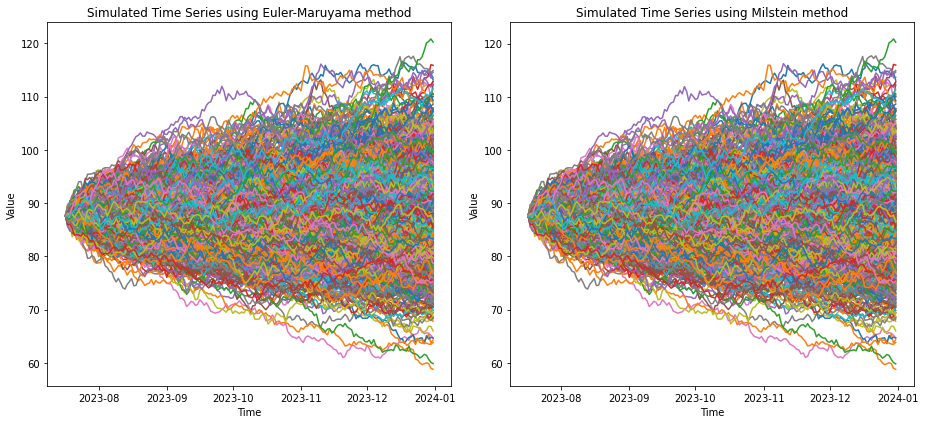

In [445]:
mc_simulator.plot_n_realisations()

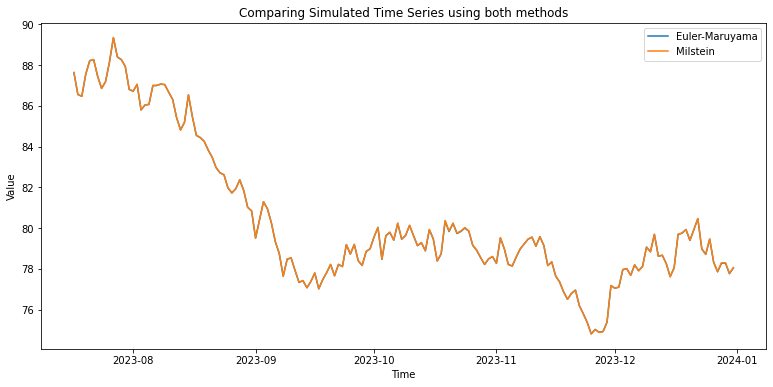

In [446]:
mc_simulator.comparing_ith_realisations(0)

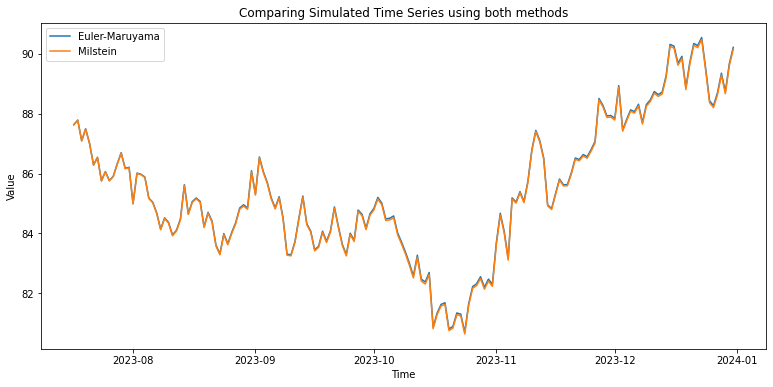

In [447]:
mc_simulator.comparing_ith_realisations(1)

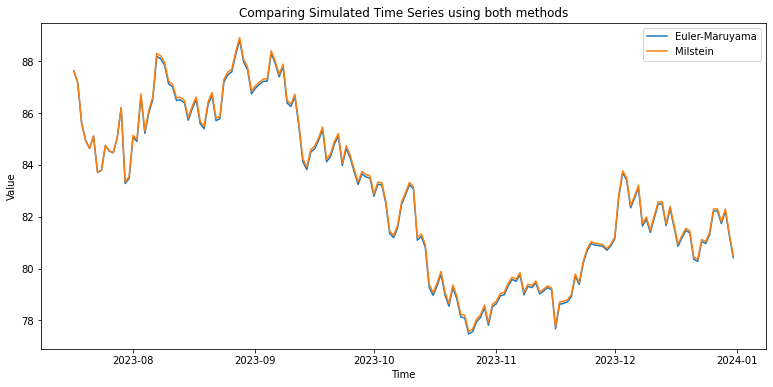

In [448]:
mc_simulator.comparing_ith_realisations(2)

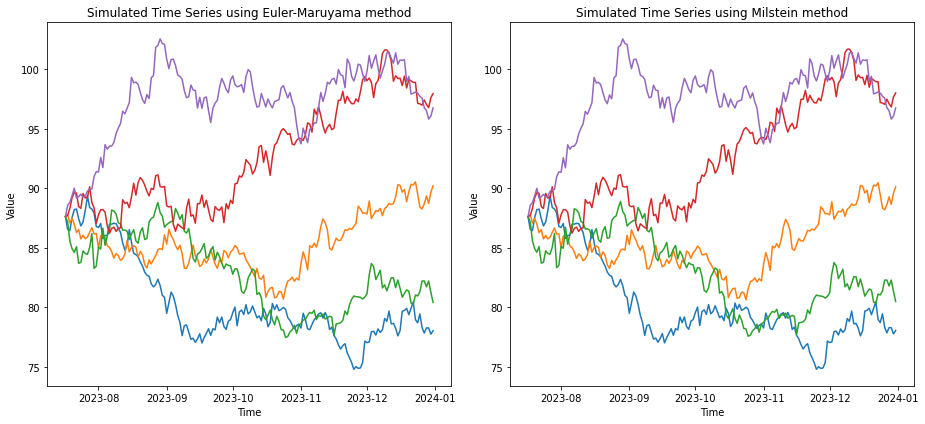

In [449]:
mc_simulator.plot_n_realisations(5)

### European Put Option

In [450]:
start_time = time.time()
mc_simulator = MC_simulator_optimised(S0, K, r, sigma, T, N, M, T0, T2)
mc_simulator.run_monte_carlo()
(EM_option_price, M_option_price, EM_SE, M_SE) = mc_simulator.get_European_option_price("p")
print("Euler-Maruyama: Estimated present value is {0} with standard error {1}".format(round(EM_option_price,4), round(EM_SE,3)))
print("Milstein: Estimated present value is {0} with standard error {1}".format(round(M_option_price,4), round(M_SE,3)))
print("Computation time is: ", round(time.time() - start_time,4))

model objects initialised...
Start running simulations...
Euler-Maruyama: Estimated present value is 12.8842 with standard error 0.251
Milstein: Estimated present value is 12.8853 with standard error 0.25
Computation time is:  0.0171


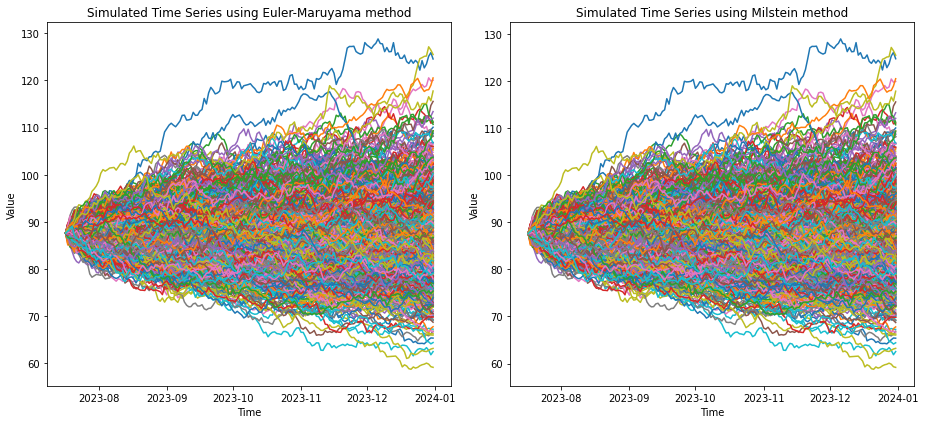

In [451]:
mc_simulator.plot_n_realisations()

# Barrier Options

1. up-and-in call option
1. up-and-out call option
1. down-and-in call option
1. down-and-out call option
1. up-and-in put option
1. up-and-out put option
1. down-and-in put option
1. down-and-out put option

In [123]:
# experimentation
N = 5
M = 5
H = 100
start_time = time.time()
mil_simulator = Milstein_fast_simulator("Milstein", S0, K, r, sigma, T, N, M)
mil_simulator.run_monte_carlo()
mil_option_price = mil_simulator.get_option_price()
print("Estimated present value is %f" % mil_option_price)
print("Computation time is: ", round(time.time() - start_time,4))

print(mil_simulator.realisations)
mask = np.any(mil_simulator.realisations >= H, axis=0)
print(mask)

cloned_rels = np.copy(mil_simulator.realisations)
cloned_rels[:,mask] = 0
print(cloned_rels, end="\n")

payoffs = np.maximum(0, K - cloned_rels[-1][cloned_rels[-1] != 0])
print(payoffs, end="\n")
C0 = np.exp(-r*T)*np.sum(payoffs)/M
print(C0, end="\n")

Estimated present value is 0.000000
Computation time is:  0.0081
[[87.63       87.63       87.63       87.63       87.63      ]
 [95.12433842 78.60291833 98.13414036 86.4468799  89.35606438]
 [93.25918279 72.97180527 98.59423816 83.53918499 97.02774849]
 [91.38505353 71.67980564 98.38344252 80.82561517 88.47349992]
 [86.2866065  75.04842713 94.02316197 78.63398136 94.61622985]
 [81.79659908 79.74757577 92.02863984 81.67423764 94.82326274]]
[False False False False False]
[[87.63       87.63       87.63       87.63       87.63      ]
 [95.12433842 78.60291833 98.13414036 86.4468799  89.35606438]
 [93.25918279 72.97180527 98.59423816 83.53918499 97.02774849]
 [91.38505353 71.67980564 98.38344252 80.82561517 88.47349992]
 [86.2866065  75.04842713 94.02316197 78.63398136 94.61622985]
 [81.79659908 79.74757577 92.02863984 81.67423764 94.82326274]]
[18.20340092 20.25242423  7.97136016 18.32576236  5.17673726]
13.846774588809518


In [452]:
class BarrierOption(MC_simulator_optimised):
    def __init__(self, S0, K, r, sigma, T, N, M, T0, T2, barrier_type, H_bound, L_bound):
        super().__init__(S0, K, r, sigma, T, N, M, T0, T2)
        self.barrier_type = barrier_type # int: corresponds to the indexes listed above
        self.H_bound = H_bound   # upper barrier
        self.L_bound = L_bound   # lower barrier
        self.em_mask = None # mask for Euler-Maruyama
        self.mil_mask = None  # mask for Milstein
        self.title = 'European Up-and-Out Call Option'
        self.main_type = "Call" if (barrier_type < 5) else "Put"
        self.em_barrier_price = None # estimated option price - Euler-Maruyama
        self.mil_barrier_price = None # estimated option price - Milstein
        self.em_barrier_payoffs = None
        self.mil_barrier_payoffs = None
    
    def calculate_option_price(self, mask, realisations, model_type):
        S_expiry = realisations[-1,:].copy()
        S_expiry[mask] = 0
        
        """
        barrier_type < 5  : call option => ST - K
        barrier_type >= 5 : put option  => K - ST
        """
        payoffs = (S_expiry[S_expiry[:]!=0] - self.K) if (self.barrier_type < 5) else (self.K - S_expiry[S_expiry[:]!=0])
        payoffs = np.maximum(0, payoffs)
        option_price = np.exp(-self.r*self.T)*np.sum(payoffs)/self.M
        
        attr_name = 'em' if model_type == 0 else 'mil'
        setattr(self, attr_name + '_mask', mask)
        setattr(self, attr_name + '_barrier_payoffs', payoffs)
        return option_price
        
    def up_and_in(self, realisations, model_type):
        self.title = 'European Up-and-In ' + ('Call Option' if (self.barrier_type < 5) else 'Put Option')
        # change realisation values to 0 based on indexing mask
        mask = np.any(realisations >= self.H_bound, axis=0)
        # reversing mask so realisations below barrier are nullified
        mask = ~mask
        return self.calculate_option_price(mask, realisations, model_type)
    
    def up_and_out(self, realisations, model_type):
        self.title = 'European Up-and-Out ' + ('Call Option' if (self.barrier_type < 5) else 'Put Option')
        # change realisation values to 0 based on indexing mask
        mask = np.any(realisations >= self.H_bound, axis=0)
        return self.calculate_option_price(mask, realisations, model_type)
    
    def down_and_in(self, realisations, model_type):
        self.title = 'European Down-and-In ' + ('Call Option' if (self.barrier_type < 5) else 'Put Option')
        # change realisation values to 0 based on indexing mask
        mask = np.any(realisations <= self.L_bound, axis=0)
        # reversing mask so realisations above barrier are nullified
        mask = ~mask
        return self.calculate_option_price(mask, realisations, model_type)

    def down_and_out(self, realisations, model_type):
        self.title = 'European Down-and-Out ' + ('Call Option' if (self.barrier_type < 5) else 'Put Option')
        # change realisation values to 0 based on indexing mask
        mask = np.any(realisations <= self.L_bound, axis=0)
        return self.calculate_option_price(mask, realisations, model_type)

    def get_Barrier_price(self):
        # price option based on barriers
        select_barrier = {
            1 : self.up_and_in,
            2 : self.up_and_out,
            3 : self.down_and_in,
            4 : self.down_and_out,
            5 : self.up_and_in,
            6 : self.up_and_out,
            7 : self.down_and_in,
            8 : self.down_and_out
        }
        
        self.em_barrier_price = select_barrier.get(self.barrier_type, self.up_and_in)(self.em_simulator.realisations, 0)
        EM_SE = self.standard_error(self.em_barrier_payoffs, self.em_barrier_price, self.M)
        
        self.mil_barrier_price = select_barrier.get(self.barrier_type, self.up_and_in)(self.mil_simulator.realisations, 1)
        Mil_SE = self.standard_error(self.mil_barrier_payoffs, self.mil_barrier_price, self.M)
        return (self.em_barrier_price, self.mil_barrier_price, EM_SE, Mil_SE)
    
    def plot_barrier_paths(self, random_walk="EM"):
        attr_name = 'em' if random_walk=="EM" else 'mil'
        random_walks = getattr(self, attr_name+"_simulator").realisations
        plt.figure(figsize=(16, 6))
        timeline = pd.date_range(start=self.T0,end=self.T2)
        
        # plot realisations
        plt.plot(timeline, random_walks[:,~getattr(self, attr_name+"_mask")],'g', alpha=0.5)
        plt.plot(self.T0, self.S0, 'g', label='active')
        plt.plot(timeline,random_walks[:,getattr(self, attr_name+"_mask")],'r', alpha=0.3)
        plt.plot(self.T0, self.S0, 'r', label='inactive')
        
        # plot barriers
        if (self.barrier_type < 3 or (self.barrier_type > 4 and self.barrier_type < 7)):
            plt.axhline(y=self.H_bound, color='k', linestyle='--', linewidth=2.0, label='H_barrier')
        else:
            plt.axhline(y=self.L_bound, color='k', linestyle='--', linewidth=2.0, label='L_barrier')
                        
        plt.axhline(y=self.K, linestyle='--', color='blue',linewidth=2.0, label='strike price')
        plt.xlabel('Time')
        plt.ylabel('Price')
        _title = self.title + " : " + ("Euler-Maruyama" if attr_name=="em" else "Milstein") + " random walks"
        plt.title(_title)
        plt.legend()
        plt.show()

## 1. European Up-and-In Call Option

In [453]:
barrier_option = BarrierOption(S0, 95, r, sigma, T, N, M, T0, T2, 1, 100, 75)
barrier_option.run_monte_carlo()
(EM_option_price, M_option_price, EM_SE, M_SE) = barrier_option.get_European_option_price('c')
(EM_barrier_price, M_barrier_price, EM_Barrier_SE, M_Barrier_SE) = barrier_option.get_Barrier_price()

results = pd.DataFrame(
    {
        'Method': ["Euler-Maruyama", "Milstein", "Euler-Maruyama", "Milstein"],
        'Option Type': [barrier_option.main_type, barrier_option.main_type, barrier_option.title, barrier_option.title],
        'Estimated Price': [EM_option_price, M_option_price, EM_barrier_price, M_barrier_price],
        'Standard Error': [EM_SE, M_SE, EM_Barrier_SE, M_Barrier_SE]
    }
)
results

model objects initialised...
Start running simulations...


Method                     Option Type  Estimated Price  \
0  Euler-Maruyama                            Call         1.283948   
1        Milstein                            Call         1.284776   
2  Euler-Maruyama  European Up-and-In Call Option         1.173116   
3        Milstein  European Up-and-In Call Option         1.174295   

   Standard Error  
0        0.107171  
1        0.107242  
2        0.101800  
3        0.101871

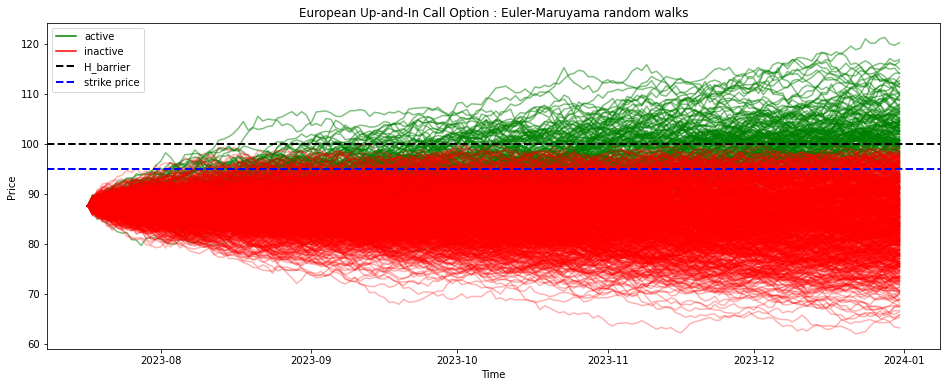

In [454]:
barrier_option.plot_barrier_paths()

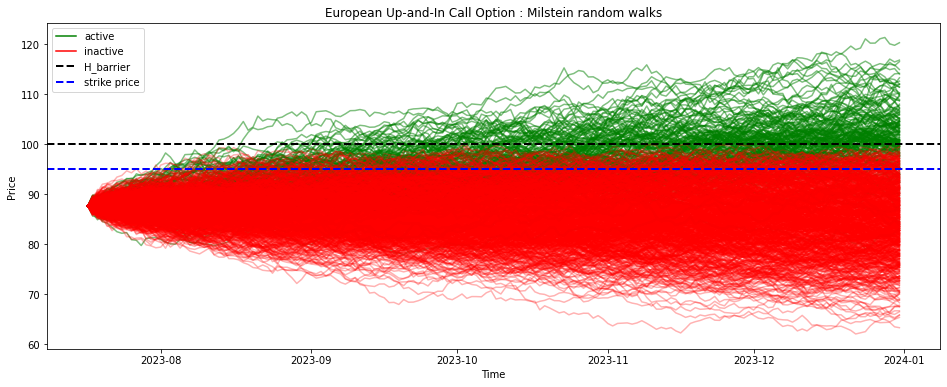

In [455]:
barrier_option.plot_barrier_paths(random_walk="m")

## 2. European Up-and-Out Call Option

In [456]:
barrier_option = BarrierOption(S0, 95, r, sigma, T, N, M, T0, T2, 2, 100, 75)
barrier_option.run_monte_carlo()
(EM_option_price, M_option_price, EM_SE, M_SE) = barrier_option.get_European_option_price('c')
(EM_barrier_price, M_barrier_price, EM_Barrier_SE, M_Barrier_SE) = barrier_option.get_Barrier_price()

results = pd.DataFrame(
    {
        'Method': ["Euler-Maruyama", "Milstein", "Euler-Maruyama", "Milstein"],
        'Option Type': [barrier_option.main_type, barrier_option.main_type, barrier_option.title, barrier_option.title],
        'Estimated Price': [EM_option_price, M_option_price, EM_barrier_price, M_barrier_price],
        'Standard Error': [EM_SE, M_SE, EM_Barrier_SE, M_Barrier_SE]
    }
)
results

model objects initialised...
Start running simulations...


Method                      Option Type  Estimated Price  \
0  Euler-Maruyama                             Call         1.220781   
1        Milstein                             Call         1.223204   
2  Euler-Maruyama  European Up-and-Out Call Option         0.109846   
3        Milstein  European Up-and-Out Call Option         0.110096   

   Standard Error  
0        0.105970  
1        0.106099  
2        0.016482  
3        0.016499

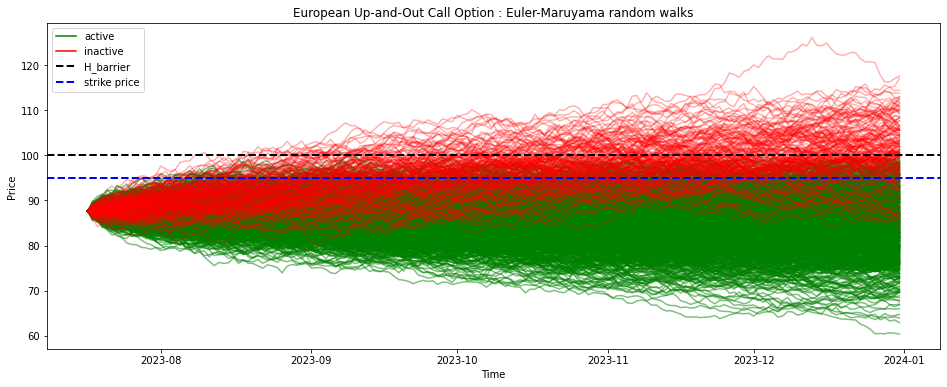

In [457]:
barrier_option.plot_barrier_paths()

## 3. European Down-and-In Call Option

In [458]:
barrier_option = BarrierOption(S0, 95, r, sigma, T, N, M, T0, T2, 3, 100, 80)
barrier_option.run_monte_carlo()
(EM_option_price, M_option_price, EM_SE, M_SE) = barrier_option.get_European_option_price('c')
(EM_barrier_price, M_barrier_price, EM_Barrier_SE, M_Barrier_SE) = barrier_option.get_Barrier_price()

results = pd.DataFrame(
    {
        'Method': ["Euler-Maruyama", "Milstein", "Euler-Maruyama", "Milstein"],
        'Option Type': [barrier_option.main_type, barrier_option.main_type, barrier_option.title, barrier_option.title],
        'Estimated Price': [EM_option_price, M_option_price, EM_barrier_price, M_barrier_price],
        'Standard Error': [EM_SE, M_SE, EM_Barrier_SE, M_Barrier_SE]
    }
)
results

model objects initialised...
Start running simulations...


Method                       Option Type  Estimated Price  \
0  Euler-Maruyama                              Call         1.288947   
1        Milstein                              Call         1.290397   
2  Euler-Maruyama  European Down-and-In Call Option         0.012537   
3        Milstein  European Down-and-In Call Option         0.012832   

   Standard Error  
0        0.103877  
1        0.103920  
2        0.006127  
3        0.006282

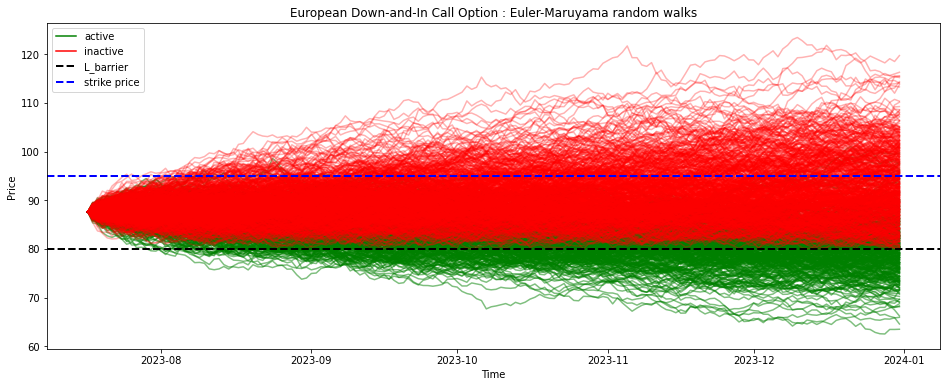

In [459]:
barrier_option.plot_barrier_paths()

## 4. European Down-and-Out Call Option

In [460]:
barrier_option = BarrierOption(S0, 95, r, sigma, T, N, M, T0, T2, 4, 100, 80)
barrier_option.run_monte_carlo()
(EM_option_price, M_option_price, EM_SE, M_SE) = barrier_option.get_European_option_price('c')
(EM_barrier_price, M_barrier_price, EM_Barrier_SE, M_Barrier_SE) = barrier_option.get_Barrier_price()

results = pd.DataFrame(
    {
        'Method': ["Euler-Maruyama", "Milstein", "Euler-Maruyama", "Milstein"],
        'Option Type': [barrier_option.main_type, barrier_option.main_type, barrier_option.title, barrier_option.title],
        'Estimated Price': [EM_option_price, M_option_price, EM_barrier_price, M_barrier_price],
        'Standard Error': [EM_SE, M_SE, EM_Barrier_SE, M_Barrier_SE]
    }
)
results

model objects initialised...
Start running simulations...


Method                        Option Type  Estimated Price  \
0  Euler-Maruyama                               Call         1.375328   
1        Milstein                               Call         1.375500   
2  Euler-Maruyama  European Down-and-Out Call Option         1.362841   
3        Milstein  European Down-and-Out Call Option         1.362876   

   Standard Error  
0        0.104299  
1        0.104371  
2        0.100905  
3        0.100992

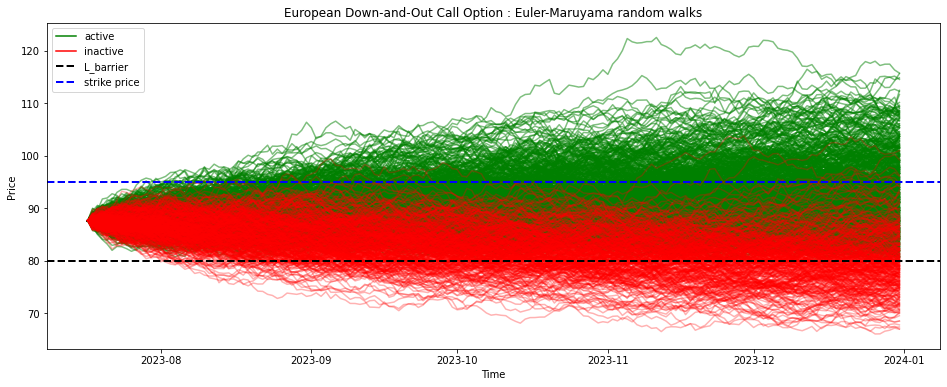

In [461]:
barrier_option.plot_barrier_paths()

## 5. European Up-and-In Put Option

In [462]:
barrier_option = BarrierOption(S0, 95, r, sigma, T, N, M, T0, T2, 5, 100, 80)
barrier_option.run_monte_carlo()
(EM_option_price, M_option_price, EM_SE, M_SE) = barrier_option.get_European_option_price('p')
(EM_barrier_price, M_barrier_price, EM_Barrier_SE, M_Barrier_SE) = barrier_option.get_Barrier_price()

results = pd.DataFrame(
    {
        'Method': ["Euler-Maruyama", "Milstein", "Euler-Maruyama", "Milstein"],
        'Option Type': [barrier_option.main_type, barrier_option.main_type, barrier_option.title, barrier_option.title],
        'Estimated Price': [EM_option_price, M_option_price, EM_barrier_price, M_barrier_price],
        'Standard Error': [EM_SE, M_SE, EM_Barrier_SE, M_Barrier_SE]
    }
)
results

model objects initialised...
Start running simulations...


Method                    Option Type  Estimated Price  \
0  Euler-Maruyama                            Put         8.228445   
1        Milstein                            Put         8.226815   
2  Euler-Maruyama  European Up-and-In Put Option         0.101307   
3        Milstein  European Up-and-In Put Option         0.100816   

   Standard Error  
0        0.219948  
1        0.219901  
2        0.024093  
3        0.024023

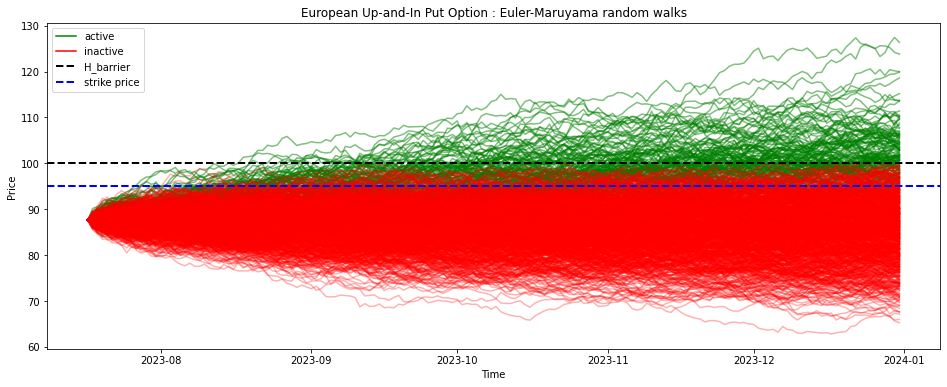

In [463]:
barrier_option.plot_barrier_paths()

## 6. European Up-and-Out Put Option

In [464]:
barrier_option = BarrierOption(S0, 95, r, sigma, T, N, M, T0, T2, 6, 100, 80)
barrier_option.run_monte_carlo()
(EM_option_price, M_option_price, EM_SE, M_SE) = barrier_option.get_European_option_price('p')
(EM_barrier_price, M_barrier_price, EM_Barrier_SE, M_Barrier_SE) = barrier_option.get_Barrier_price()

results = pd.DataFrame(
    {
        'Method': ["Euler-Maruyama", "Milstein", "Euler-Maruyama", "Milstein"],
        'Option Type': [barrier_option.main_type, barrier_option.main_type, barrier_option.title, barrier_option.title],
        'Estimated Price': [EM_option_price, M_option_price, EM_barrier_price, M_barrier_price],
        'Standard Error': [EM_SE, M_SE, EM_Barrier_SE, M_Barrier_SE]
    }
)
results

model objects initialised...
Start running simulations...


Method                     Option Type  Estimated Price  \
0  Euler-Maruyama                             Put         8.020552   
1        Milstein                             Put         8.021193   
2  Euler-Maruyama  European Up-and-Out Put Option         7.897284   
3        Milstein  European Up-and-Out Put Option         7.898226   

   Standard Error  
0        0.225648  
1        0.225580  
2        0.199335  
3        0.199246

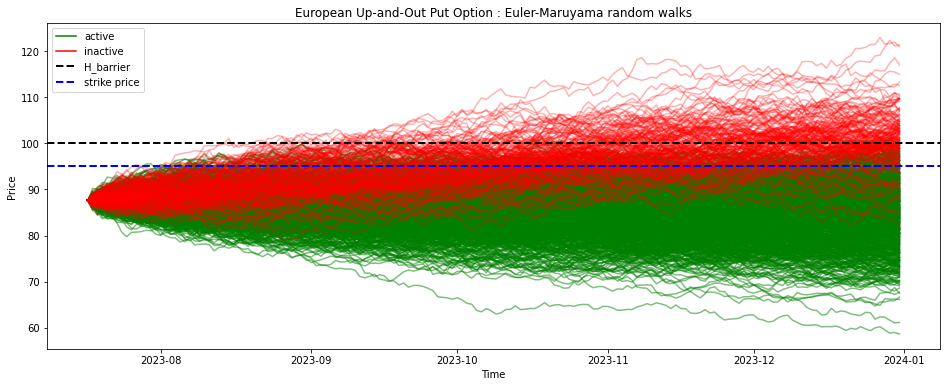

In [465]:
barrier_option.plot_barrier_paths()

## 7. European Down-and-In Put Option

In [466]:
barrier_option = BarrierOption(S0, 95, r, sigma, T, N, M, T0, T2, 7, 100, 80)
barrier_option.run_monte_carlo()
(EM_option_price, M_option_price, EM_SE, M_SE) = barrier_option.get_European_option_price('p')
(EM_barrier_price, M_barrier_price, EM_Barrier_SE, M_Barrier_SE) = barrier_option.get_Barrier_price()

results = pd.DataFrame(
    {
        'Method': ["Euler-Maruyama", "Milstein", "Euler-Maruyama", "Milstein"],
        'Option Type': [barrier_option.main_type, barrier_option.main_type, barrier_option.title, barrier_option.title],
        'Estimated Price': [EM_option_price, M_option_price, EM_barrier_price, M_barrier_price],
        'Standard Error': [EM_SE, M_SE, EM_Barrier_SE, M_Barrier_SE]
    }
)
results

model objects initialised...
Start running simulations...


Method                      Option Type  Estimated Price  \
0  Euler-Maruyama                              Put         8.084853   
1        Milstein                              Put         8.084981   
2  Euler-Maruyama  European Down-and-In Put Option         5.324983   
3        Milstein  European Down-and-In Put Option         5.323699   

   Standard Error  
0        0.222939  
1        0.222890  
2        0.211402  
3        0.211370

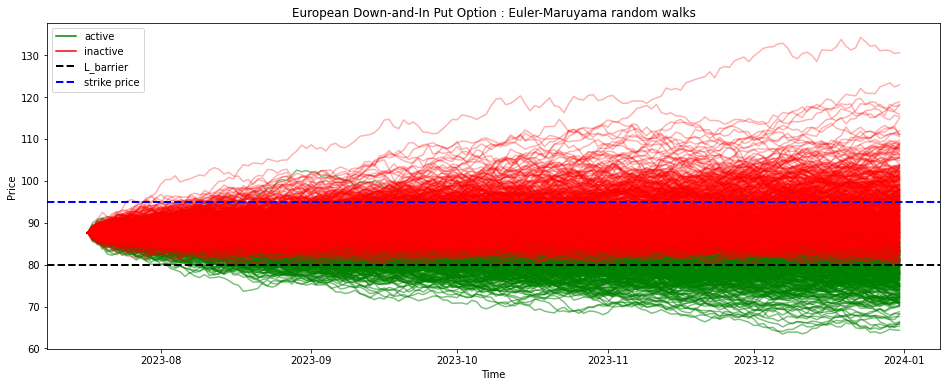

In [467]:
barrier_option.plot_barrier_paths()

## 8. European Down-and-Out Put Option

In [468]:
barrier_option = BarrierOption(S0, 95, r, sigma, T, N, M, T0, T2, 8, 100, 80)
barrier_option.run_monte_carlo()
(EM_option_price, M_option_price, EM_SE, M_SE) = barrier_option.get_European_option_price('p')
(EM_barrier_price, M_barrier_price, EM_Barrier_SE, M_Barrier_SE) = barrier_option.get_Barrier_price()

results = pd.DataFrame(
    {
        'Method': ["Euler-Maruyama", "Milstein", "Euler-Maruyama", "Milstein"],
        'Option Type': [barrier_option.main_type, barrier_option.main_type, barrier_option.title, barrier_option.title],
        'Estimated Price': [EM_option_price, M_option_price, EM_barrier_price, M_barrier_price],
        'Standard Error': [EM_SE, M_SE, EM_Barrier_SE, M_Barrier_SE]
    }
)
results

model objects initialised...
Start running simulations...


Method                       Option Type  Estimated Price  \
0  Euler-Maruyama                               Put         7.962961   
1        Milstein                               Put         7.962779   
2  Euler-Maruyama  European Down-and-Out Put Option         2.634648   
3        Milstein  European Down-and-Out Put Option         2.646667   

   Standard Error  
0        0.218254  
1        0.218139  
2        0.110973  
3        0.111311

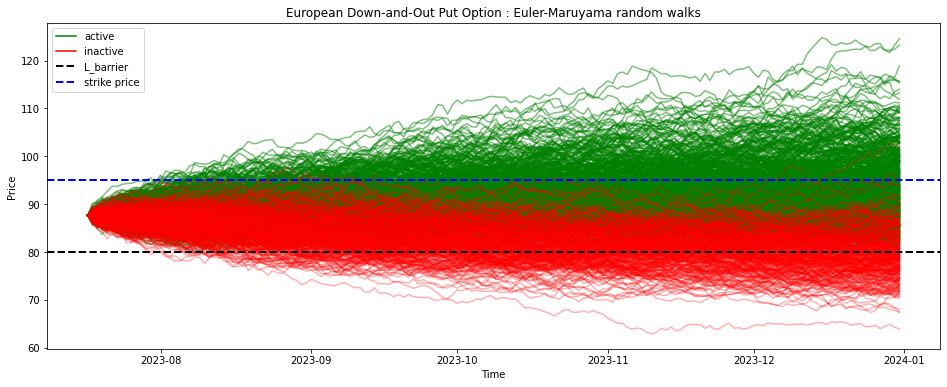

In [469]:
barrier_option.plot_barrier_paths()

# Asian Option

In [524]:
class AsianOption(MC_simulator_optimised):
    def __init__(self, S0, K, r, sigma, T, N, M, T0, T2, T1):
        super().__init__(S0, K, r, sigma, T, N, M, T0, T2)
        self.T1 = T1 # start date of average price period
        self.em_mask = None # mask for Euler-Maruyama
        self.m_mask = None  # mask for Milstein
        self.title = 'European Asian'
        self.main_type = "Call"
        self.em_asian_price = None  # estimated option price - Euler-Maruyama
        self.mil_asian_price = None # estimated option price - Milstein
        self.em_asian_payoffs = None
        self.mil_asian_payoffs = None
        self.em_avg_prices = None  # average price
        self.mil_avg_prices = None # average price
    
    def calculate_option_price(self, realisations, option_type, model_type):
        # average price of each realisation path
        avg_prices = np.mean(realisations, axis=0)

        payoffs = (avg_prices - self.K) if (option_type=="c") else (self.K - avg_prices)
        payoffs = maximum(payoffs, 0)
        option_price = exp(-self.r*self.T) * sum(payoffs)/self.M
        
        attr_name = 'em' if model_type == 0 else 'mil'
        setattr(self, attr_name + '_asian_payoffs', payoffs)
        setattr(self, attr_name + '_avg_prices', avg_prices)
        return option_price
    
    def get_Asian_price(self, option_type):
        self.main_type = "Call" if option_type=='c' else "Put"
        self.title = self.title + ' ' + self.main_type + " option"
        
        start_point = (self.T1 - self.T0).days -1 # starting date of time period for calculating average
        self.em_asian_price = self.calculate_option_price(self.em_simulator.realisations[:, start_point:], option_type, 0)
        EM_SE = self.standard_error(self.em_asian_payoffs, self.em_asian_price, self.M)

        self.mil_asian_price = self.calculate_option_price(self.mil_simulator.realisations[:, start_point:], option_type, 1)
        M_SE = self.standard_error(self.mil_asian_payoffs, self.mil_asian_price, self.M)
        return (self.em_asian_price, self.mil_asian_price, EM_SE, M_SE)
    
    def plot_asian_paths(self, random_walk="EM"):
        attr_name = 'em' if random_walk=="EM" else 'mil'
        random_walks = getattr(self, attr_name+"_simulator").realisations
        plt.figure(figsize=(16, 6))
        
        # plot realisations
        timeline = pd.date_range(start=self.T0,end=self.T2)
        plt.plot(timeline, random_walks)
        
        # highlight average price of region
        plt.axvspan(self.T1, self.T2, color="cyan", alpha=0.5)
        plt.axvline(x=self.T1, color="orange", linestyle='-', linewidth=5, label='$T_1$')
        plt.axvline(x=self.T2, color="red", linestyle='-', linewidth=5, label='$T_2$')

        # plot strike price
        plt.axhline(y=self.K, linestyle='--', color='blue',linewidth=2.0, label='strike price')

        plt.xlabel('Time')
        plt.ylabel('Price')
        _title = self.title + " : " + ("Euler-Maruyama" if attr_name=="em" else "Milstein") + " random walks"
        plt.title(_title)
        plt.legend()
        plt.show()

### European Asian Call Option - Average of 30 days before expiry

In [525]:
asian_call_option = AsianOption(S0, K, r, sigma, T, N, M, T0, T2, T1)
asian_call_option.run_monte_carlo()
(EM_option_price, M_option_price, EM_SE, M_SE) = asian_call_option.get_European_option_price('c')
(EM_asian_price, M_asian_price, EM_Asian_SE, M_Asian_SE) = asian_call_option.get_Asian_price('c')

results = pd.DataFrame(
    {
        'Method': ["Euler-Maruyama", "Milstein", "Euler-Maruyama", "Milstein"],
        'Option Type': [asian_call_option.main_type, asian_call_option.main_type, asian_call_option.title, asian_call_option.title],
        'Estimated Price': [EM_option_price, M_option_price, EM_asian_price, M_asian_price],
        'Standard Error': [EM_SE, M_SE, EM_Asian_SE, M_Asian_SE]
    }
)
results

model objects initialised...
Start running simulations...


Method                 Option Type  Estimated Price  Standard Error
0  Euler-Maruyama                        Call         0.455649        0.059878
1        Milstein                        Call         0.457154        0.060043
2  Euler-Maruyama  European Asian Call option         0.018264        0.007098
3        Milstein  European Asian Call option         0.018636        0.007200

In [526]:
asian_call_option.plot_asian_paths()

### European Asian Call Option - Average of 60 days before expiry

In [527]:
T1_60 = date(2023,11,1)
asian_call_option_60 = AsianOption(S0, K, r, sigma, T, N, M, T0, T2, T1_60)
asian_call_option_60.run_monte_carlo()
(EM_option_price, M_option_price, EM_SE, M_SE) = asian_call_option_60.get_European_option_price('c')
(EM_asian_price, M_asian_price, EM_Asian_SE, M_Asian_SE) = asian_call_option_60.get_Asian_price('c')

results = pd.DataFrame(
    {
        'Method': ["Euler-Maruyama", "Milstein", "Euler-Maruyama", "Milstein"],
        'Option Type': [asian_call_option_60.main_type, asian_call_option_60.main_type, asian_call_option_60.title, asian_call_option_60.title],
        'Estimated Price': [EM_option_price, M_option_price, EM_asian_price, M_asian_price],
        'Standard Error': [EM_SE, M_SE, EM_Asian_SE, M_Asian_SE]
    }
)
results

model objects initialised...
Start running simulations...


Method                 Option Type  Estimated Price  Standard Error
0  Euler-Maruyama                        Call         0.470371        0.066619
1        Milstein                        Call         0.470476        0.066637
2  Euler-Maruyama  European Asian Call option         0.024344        0.008681
3        Milstein  European Asian Call option         0.024391        0.008676

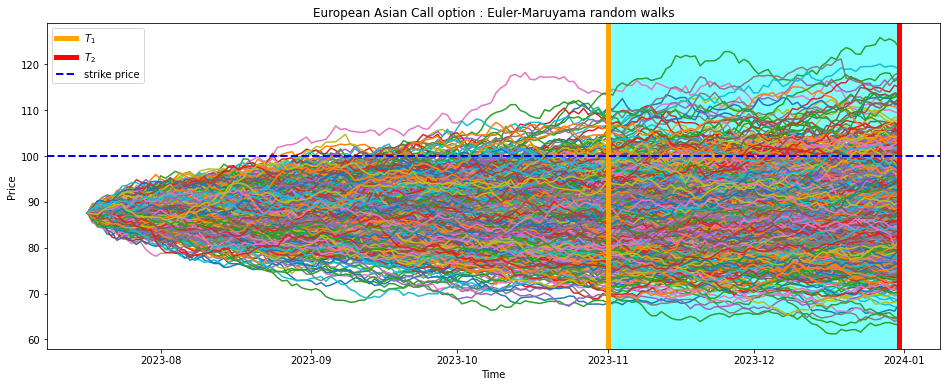

In [528]:
asian_call_option_60.plot_asian_paths()

### European Asian Put Option - Average of 30 days before expiry

In [517]:
asian_put_option = AsianOption(S0, K, r, sigma, T, N, M, T0, T2, T1)
asian_put_option.run_monte_carlo()
(EM_option_price, M_option_price, EM_SE, M_SE) = asian_put_option.get_European_option_price('p')
(EM_asian_price, M_asian_price, EM_Asian_SE, M_Asian_SE) = asian_put_option.get_Asian_price('p')

results = pd.DataFrame(
    {
        'Method': ["Euler-Maruyama", "Milstein", "Euler-Maruyama", "Milstein"],
        'Option Type': [asian_put_option.main_type, asian_put_option.main_type, asian_put_option.title, asian_put_option.title],
        'Estimated Price': [EM_option_price, M_option_price, EM_asian_price, M_asian_price],
        'Standard Error': [EM_SE, M_SE, EM_Asian_SE, M_Asian_SE]
    }
)
results

model objects initialised...
Start running simulations...


Method                Option Type  Estimated Price  Standard Error
0  Euler-Maruyama                        Put        12.005073        0.254634
1        Milstein                        Put        12.006158        0.254680
2  Euler-Maruyama  European Asian Put option        10.388644        0.150159
3        Milstein  European Asian Put option        10.389574        0.150185

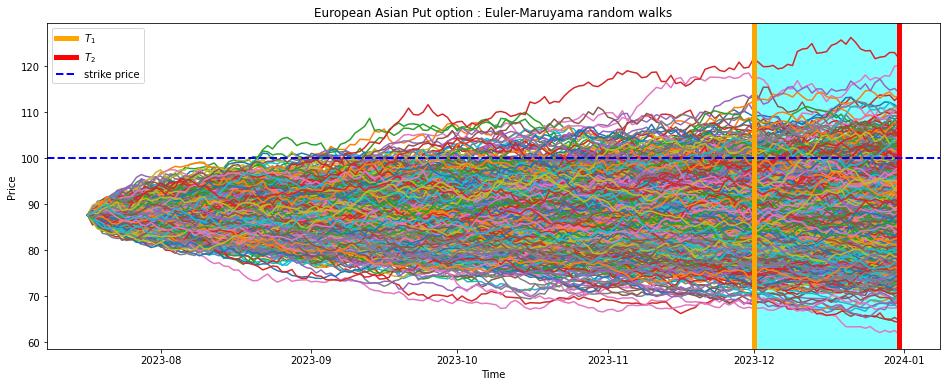

In [518]:
asian_put_option.plot_asian_paths()

### European Asian Put Option - Average of 60 days before expiry

In [529]:
T1_60 = date(2023,11,1)
asian_put_option_60 = AsianOption(S0, K, r, sigma, T, N, M, T0, T2, T1_60)
asian_put_option_60.run_monte_carlo()
(EM_option_price, M_option_price, EM_SE, M_SE) = asian_put_option_60.get_European_option_price('p')
(EM_asian_price, M_asian_price, EM_Asian_SE, M_Asian_SE) = asian_put_option_60.get_Asian_price('p')

results = pd.DataFrame(
    {
        'Method': ["Euler-Maruyama", "Milstein", "Euler-Maruyama", "Milstein"],
        'Option Type': [asian_put_option_60.main_type, asian_put_option_60.main_type, asian_put_option_60.title, asian_put_option_60.title],
        'Estimated Price': [EM_option_price, M_option_price, EM_asian_price, M_asian_price],
        'Standard Error': [EM_SE, M_SE, EM_Asian_SE, M_Asian_SE]
    }
)
results

model objects initialised...
Start running simulations...


Method                Option Type  Estimated Price  Standard Error
0  Euler-Maruyama                        Put        12.916984        0.255440
1        Milstein                        Put        12.916770        0.255364
2  Euler-Maruyama  European Asian Put option        11.093879        0.158296
3        Milstein  European Asian Put option        11.094139        0.158247

In [530]:
asian_put_option_60.plot_asian_paths()